4.24 修改意见

再拓展一下，把全部2天的数据都算了
测试5的点位有没有找出来？
我猜大部分时间花在了IO上面。你看看能不能再这之前把要计算的通道选好，内存读到数据后做计算，计算1个通道的psd跟100个通道应该差不太多，这样吧，把每20个通道算一个结果，我们把这条路上的信号水平都算出来
不要直接画图。我们需要中间过程的结果来做更深入的分析，把中间结果保存好


In [10]:
# last modified 2024/4/24 
# %matplotlib ipympl
%matplotlib inline
import h5py 
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
import os
import datetime
import matplotlib
import logging
import csv
import time
def concat(flist , start = 0 , span = 20 ):
    datalist = []
    for fname in flist[ start : start + span ]:
        data = dp.read_das(fname)[::20]
        datalist.append(data)

    data = np.concatenate(datalist, axis = 1)
    utc_datetime = datetime.datetime.strptime(flist[start][-22 : -7],'%Y%m%d_%H%M%S') + datetime.timedelta(hours=+8)
    utc_day = utc_datetime.strftime("%m-%d %H:%M")
    print("cat")
    return data , utc_datetime, utc_day 


def psd(startn,endn):
    # 创建一个dataset
    span_each_pic = 10 #12h -> 50min
    concat_time = 0
    ch_list = [20*i for i in range(148)]
    for n in range(startn, endn):
        data , utc_datetime, utc_day = concat(flist , start= span_each_pic * n ,span= span_each_pic)
        nfft = 30000
        fs = 2000
        start = time.time()
        print(data.shape)


        for i in range(len(ch_list)):
            with h5py.File('../output/DAS/psd_5_11/test2_ch'+str(ch_list[i])+'.hdf5', 'a') as f:
                # g =  f.create_group(str(ch_list[i]))  
                [f1,Pxx1] = signal.welch(data[i],                   # 随机信号
                                nfft=nfft,               # 每个窗的长度
                                fs=fs,                   # 采样频率   
                                # detrend='mean',          # 去掉均值
                                window=np.hanning(nfft), # 加汉尼窗
                                noverlap=int(nfft*3/4),  # 每个窗重叠75%的数据
                                )        # 求单边谱
                # print(f1)
                f.create_dataset(str(utc_day),  data=Pxx1 , chunks=len(Pxx1))
                f.close()

        concat_time +=  time.time() -start
        print(n , "psd运行时间:%.2f min %d s"%( int(concat_time / 60) , concat_time%60) , datetime.datetime.now() , utc_day, "check in ")

flist = glob.glob('../../czyc/test2/*631.h5')
flist.sort()
print(len(flist))

path = '../output/DAS/psd_5_11/'
if not os.path.exists(path):
    os.makedirs(path)

print(int(len(flist)/10))



psd(startn=0 , endn=10) #31m39s / 14min 18s --->
# h5fname = '../output/DAS/psd_4_25_2.hdf5'
# psd(h5fname , 136 , 144 ) #31m39s / 14min 18s --->



12059
1205
cat
(148, 600000)
0 psd运行时间:0.00 min 0 s 2024-05-11 23:21:58.010971 12-28 16:23 check in 
0 psd运行时间:0.00 min 0 s 2024-05-11 23:21:58.202117 12-28 16:23 check in 
0 psd运行时间:0.00 min 1 s 2024-05-11 23:21:58.369699 12-28 16:23 check in 
0 psd运行时间:0.00 min 1 s 2024-05-11 23:21:58.578049 12-28 16:23 check in 
0 psd运行时间:0.00 min 2 s 2024-05-11 23:21:58.746246 12-28 16:23 check in 
0 psd运行时间:0.00 min 3 s 2024-05-11 23:21:58.929906 12-28 16:23 check in 
0 psd运行时间:0.00 min 4 s 2024-05-11 23:21:59.075894 12-28 16:23 check in 
0 psd运行时间:0.00 min 6 s 2024-05-11 23:21:59.228183 12-28 16:23 check in 
0 psd运行时间:0.00 min 7 s 2024-05-11 23:21:59.374028 12-28 16:23 check in 
0 psd运行时间:0.00 min 9 s 2024-05-11 23:21:59.554372 12-28 16:23 check in 
0 psd运行时间:0.00 min 11 s 2024-05-11 23:21:59.733006 12-28 16:23 check in 
0 psd运行时间:0.00 min 13 s 2024-05-11 23:21:59.896269 12-28 16:23 check in 
0 psd运行时间:0.00 min 15 s 2024-05-11 23:22:00.093016 12-28 16:23 check in 
0 psd运行时间:0.00 min 18 s 2024-05-

KeyboardInterrupt: 

一些问题，当采样间距和采样频率改变的时候，统一方式处理数据需要做不一样的参数
之前 2m 1kh 15s一个文件 读取 1s一个
现在 1m 2kh 30s一个文件 读取时间翻四倍，50s才拼接完，+ 50s计算时间
之前10s+10s,现在50+50，5min数据需要30s计算，40s读取




test3 nfft=30s,5min per psd, psd length 15001, oneside
72*20 files per output, 6h data per output file, 

In [ ]:
# h5fname = '../output/DAS/psd_4_25_3_.hdf5'
# psd(h5fname , 144 , 216 ) #27m35s / 11min 33s --->

In [ ]:
h5fname = '../output/DAS/psd_4_25_4_.hdf5'
psd(h5fname , 216 , 288 ) #31m39s / 14min 18s --->

In [ ]:
# h5fname = '../output/DAS/psd_4_25_5.hdf5'
# psd(h5fname , 288 , 360 ) #36m57s / 13min 20s --->

In [ ]:
# h5fname = '../output/DAS/psd_4_25_6.hdf5'
# psd(h5fname , 360 , 432 ) #34m29s / 13min 54s --->

In [ ]:
h5fname = '../output/DAS/psd_4_25_7.hdf5'
psd(h5fname , 432 , 433 ) #31m39s / 14min 18s --->

-----------read 40 ------------
49
49
(588, 30001)
588


/tmp/ipykernel_8234/2480069677.py:32: RuntimeWarning: divide by zero encountered in log
  psd = np.log(psd)


FileNotFoundError: [Errno 2] No such file or directory: '../output/DAS/psd_5_9/ch_40_psd_.png'

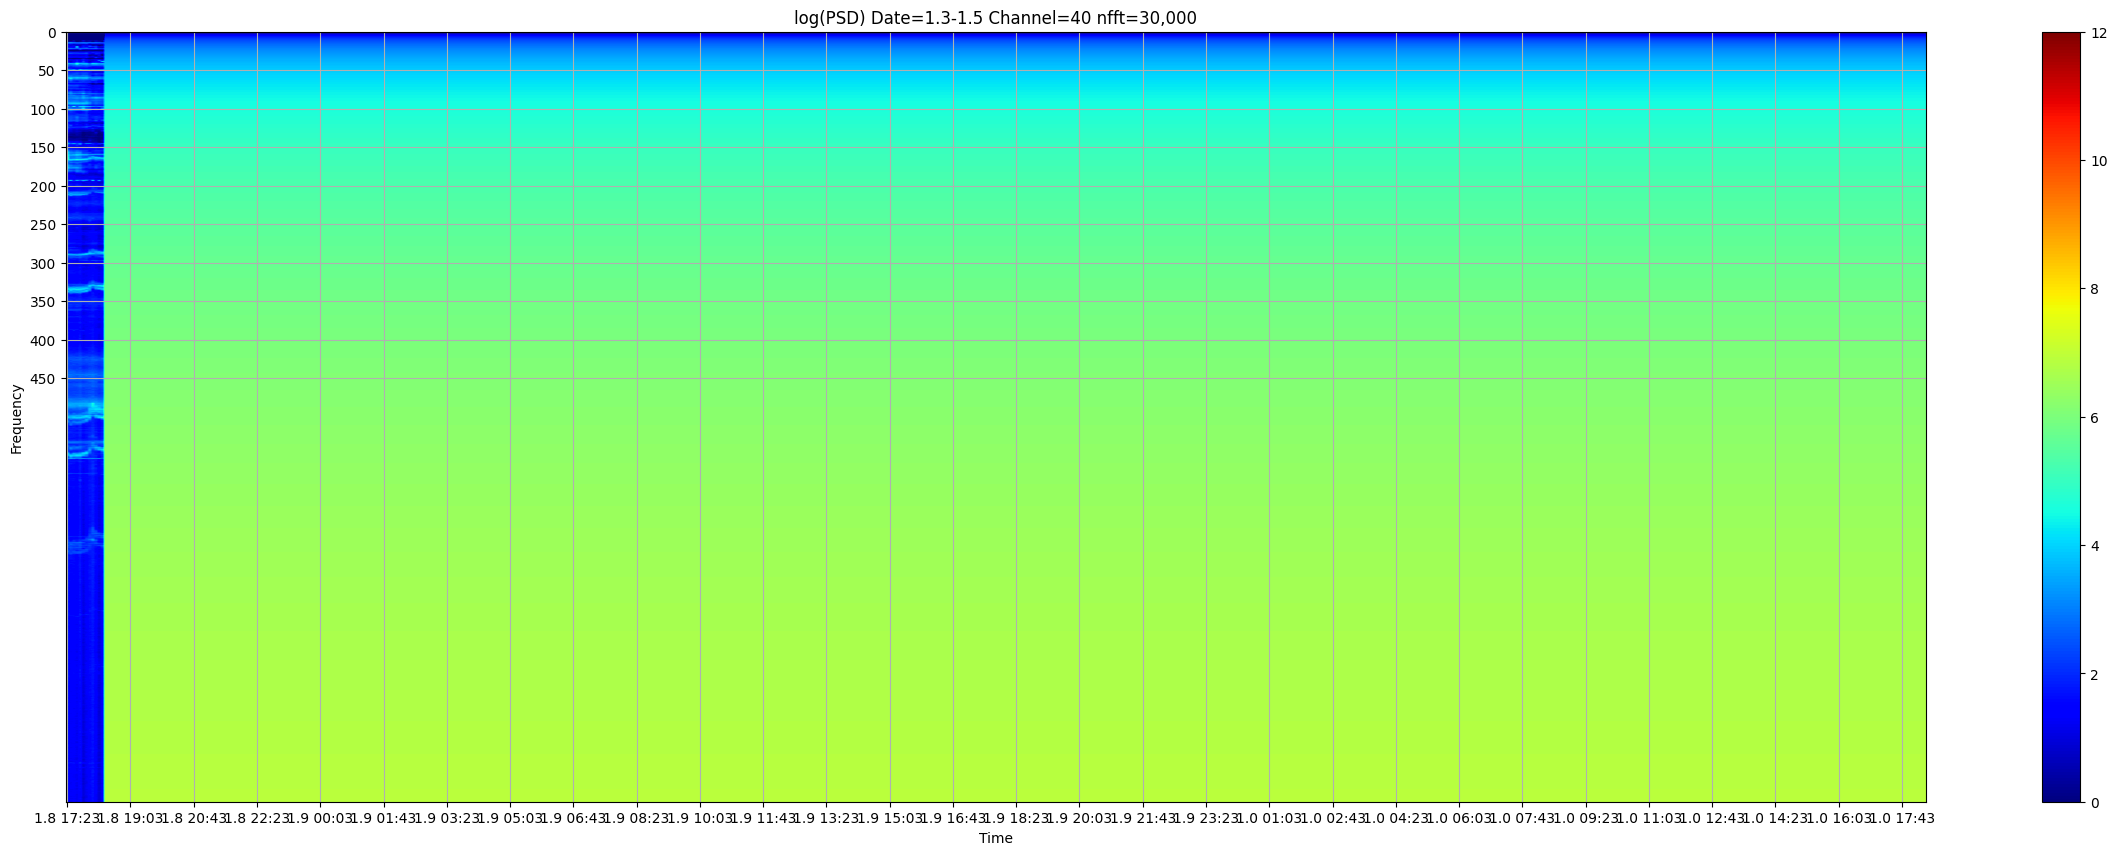

In [9]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
ch_list = [40,150,300,450,600,700,830,910,1000,1200,1420]
# ch_list = range(0,1479,10)
for ch in ch_list:
    psd = []
    all_time = []
    for fi in range(1,50):
        with h5py.File('../output/DAS/psd_5_10/test2_'+str(fi)+'.hdf5', 'r') as f:
            if len(f[str(ch)].keys()) == 1 :
                dset = f[str(ch)]['01']
            else:
                dset = f[str(ch)]
            time = [key for key in dset.keys()]
            # print(time)
            # start = time.index('20:00:12')
            # time = time[start:]+time[:start]
            # print(time)

            psd.append(  [dset[key][:] for key in time])
            all_time.append(time[:])
            f.close()
    print("-----------read",ch,"------------")
    
    print(len(psd))
    print(len(all_time))
    psd = np.concatenate(psd)
    time = np.concatenate(all_time)
    print(psd.shape)
    print(len(time))
    psd = np.log(psd)
    plt.figure(figsize=(30,10))
    plt.imshow(psd.T, aspect='auto', cmap='jet',vmin=0, vmax=12)
    # plt.imshow(psd.T, aspect='auto', cmap='viridis')
    plt.grid(alpha = 1)

    xstick = range(0, len(time) , 20)
    ystick = [1500*i for i in range(10)]
    # print(f['frequency'].shape)

    plt.xticks(xstick , ["1."+time[i][-7]+" "+time[i][-5:]  for i in xstick],rotation = 0)
    # plt.xticks(xstick , [time[i][:2]+" "+time[i][3:]  for i in xstick],rotation = 0)

    plt.yticks(ystick , ['%d'% (i/30.)  for i in ystick])
    plt.ylabel("Frequency")
    plt.xlabel("Time")
    plt.title("log(PSD) Date=1.3-1.5 Channel="+str(ch)+" nfft=30,000")

    plt.colorbar()
    plt.savefig('../output/DAS/psd_5_9/ch_'+str(ch)+'_psd_.png') #10s per pic
    plt.close()


4.26 我们现在可以取噪音录音的时间，把所有通道的结果画出来，画一个图，横轴是通道，比如选取下午2-3点的psd，每个通道作为一个列

In [3]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
all_psd = []
ch_list = range(0,1479,10)
for ch in ch_list:
    psd = []
    for fi in range(1,8):
        with h5py.File('../output/DAS/psd_4_25_'+str(fi)+'.hdf5', 'r') as f:
            if len(f[str(ch)].keys()) == 1 :
                dset = f[str(ch)]['01']
            else:
                dset = f[str(ch)]
            time = [key for key in dset.keys()]
            print("time",fi,time)
            start = time.index('04 15:10') #fi = 3  
            end= time.index('04 15:40')
            # start = time.index('01-05 03:10') #fi = 5  test5: 3:10-3:40
            # end= time.index('01-05 03:40')
            time = time[start:end+1]
            # print(time)

            psd.append(  [dset[key][:] for key in time])
            all_time.append(time[:])
            f.close()
    print("-----------read",ch,"------------")
    
    print("len(psd)",len(psd))
    psd = np.mean(psd,axis=1) 
    print("len(psd)",len(psd))
    print("psd.shape",psd.shape)
    print("len(time)",len(time))
    psd = np.log(psd)
    all_psd.append(psd[0])
    print("len all_psd",len(all_psd))
all_psd= np.array(all_psd)
print(all_psd.shape)
plt.figure(figsize=(30,8))
plt.imshow(all_psd.T, aspect='auto', cmap='jet',vmin=0, vmax=12)
# plt.imshow(psd.T, aspect='auto', cmap='viridis')

xstick = range(0, len(ch_list) , 5 )
ystick = [1500*i for i in range(10)]
# print(f['frequency'].shape)

plt.xticks(xstick ,[ch_list[i]  for i in xstick] ,rotation = 0)

plt.yticks(ystick , ['%d'% (i/30.)  for i in ystick])
plt.ylabel("Frequency")
plt.xlabel("Channel")
plt.grid()

# plt.title("log(mean(PSD)) test1=1.4 14:10-14:40 nfft=30,000")
# plt.title("log(mean(PSD)) test2=1.4 14:40-15:10 nfft=30,000")
plt.title("log(mean(PSD)) test3=1.4 15:10-15:40 nfft=30,000")
# plt.title("log(mean(PSD)) test4=1.5 02:00-02:25 nfft=30,000")
# plt.title("log(mean(PSD)) test5=1.5  03:10-03:40 nfft=30,000")

plt.colorbar()
plt.savefig('../output/DAS/test3_psd.png') #10s per pic
plt.show()
plt.close()
#5-10s


time 1 ['03:22:05', '03:22:10', '03:22:15', '03:22:20', '03:22:25', '03:22:30', '03:22:35', '03:22:40', '03:22:45', '03:22:50', '03:22:55', '03:23:00', '03:23:05', '03:23:10', '03:23:15', '03:23:20', '03:23:25', '03:23:30', '03:23:35', '03:23:40', '03:23:45', '03:23:50', '03:23:55', '04:00:00', '04:00:05', '04:00:10', '04:00:15', '04:00:20', '04:00:25', '04:00:30', '04:00:35', '04:00:40', '04:00:45', '04:00:50', '04:00:55', '04:01:00', '04:01:05', '04:01:10', '04:01:15', '04:01:20', '04:01:25', '04:01:30', '04:01:35', '04:01:40', '04:01:45', '04:01:50', '04:01:55', '04:02:00', '04:02:05', '04:02:10', '04:02:15', '04:02:20', '04:02:25', '04:02:30', '04:02:35', '04:02:40', '04:02:45', '04:02:50', '04:02:55', '04:03:00', '04:03:05', '04:03:10', '04:03:15', '04:03:20', '04:03:25', '04:03:30', '04:03:35', '04:03:40', '04:03:45', '04:03:50', '04:03:55', '04:04:00']


ValueError: '04 15:10' is not in list

录音数据的psd有没有更新？和这里的结果对比一下。尤其是test5，需要找到对应的通道

以下是计算录音的psd

In [ ]:
import librosa
import glob
from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
# Load the audio file
path = '../output/noise/'
if not os.path.exists(path):
    os.makedirs(path)
    print("Folder created")
else:
    print("Folder already exists")


with h5py.File('../output/DAS/psd_4_29_noise_psd_.hdf5', 'a') as f:

    for n in range(1,6):
        test_n = str(n)
        AUDIO_FILE = '../噪音数据/2024.1.4_留仙大道噪声测试/测试'+test_n+'/测试'+test_n+'.m4a'
        samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)
        samples = samples[ : 32421888]

        data = samples
        # data1 = dp.das_preprocess(data)
        nt = data.shape[0]

        # window = signal.windows.tukey(nt, 0.2) #taping
        # data2 = data * window[:]
        # sos = signal.butter(6, 400, 'lp', fs=sample_rate, output='sos') # lowpass
        # data2 = signal.sosfiltfilt(sos, data2)
        nfft = 30*44100 #psd 窗长度

        # data2 = dp.das_preprocess(data2)
        print(samples.size , sample_rate)

        N = samples.size
        #pdt
        x = data
        
        fs = sample_rate
        plt.figure(figsize=(12,12))
        plt.axis([0,20000,-120,-40])
        plt.title("test_"+test_n)

        [Pxx1,f1] = plt.psd(x,                       # 随机信号
                        NFFT=nfft,               # 每个窗的长度
                        Fs=fs,                   # 采样频率
                        detrend='mean',          # 去掉均值
                        window=np.hanning(nfft), # 加汉尼窗
                        noverlap=int(nfft*3/4),  # 每个窗重叠75%的数据
                        sides='onesided')        # 求双边谱

        plt.savefig(path+'/test'+test_n+'_noise_psdv3.png')
        plt.show()
        plt.close
        f.create_dataset(test_n,  data=Pxx1)
    f.create_dataset("frequencies",data=f1)





对比录音和das的psd结果，大概能对应通道数

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

def read_psd(start , end , fi, ch):
    psd = []
    with h5py.File('../output/DAS/psd_4_25_'+str(fi)+'.hdf5', 'r') as fd:
        if len(fd[str(ch)].keys()) == 1 :
            dset = fd[str(ch)]['01']
        else:
            dset = fd[str(ch)]
        time = [key for key in dset.keys()]
        # print("time",fi,time)
        start = time.index(start) #fi = 3  
        end= time.index(end)
        # start = time.index('01-05 03:10') #fi = 5  test5: 3:10-3:40
        # end= time.index('01-05 03:40')
        time = time[start:end]
        # print(time)

        psd.append(  [dset[key][:] for key in time])
        fd.close()

    psd = np.mean(psd,axis=1)[0]
    frequencies = np.linspace(0,500,15001)
    return psd , frequencies



def noiseVSdas(ch_list , axis , save_path):
    with h5py.File('../output/DAS/psd_4_29_noise_psd_.hdf5', 'r') as fn:
        noise1 = fn['1'][:] * pow(10,10)
        frequency = fn['frequencies'][:]
        ch1 = ch_list[0]
        psd1 , frequencies = read_psd('04 14:10' , '04 14:40' , 3 , ch1)
        # print(psd1, frequencies)
        plt.figure(figsize=(18,12))
        plt.subplot(231)
        plt.plot( frequency ,noise1)
        plt.plot( frequencies ,psd1 , 'r')
        plt.yscale('log')
        plt.axis(axis)
        plt.title("noise1 VS ch"+str(ch1))



        noise2 = fn['2'][:] *  pow(10,10)
        ch2 = ch_list[1]
        psd2 , frequencies = read_psd('04 14:40' , '04 15:10' , 3 , ch2)
        # print(psd2, frequencies)
        plt.subplot(232)
        plt.plot( frequency ,noise2)
        plt.plot( frequencies ,psd2 , 'r')
        plt.yscale('log')
        plt.axis(axis)
        plt.title("noise2 VS ch"+str(ch2))

        noise3 = fn['3'][:] *  pow(10,10)
        ch3 = ch_list[2]
        psd3 , frequencies = read_psd('04 15:10' , '04 15:40' , 3 , ch3)
        # print(psd3, frequencies)
        
        plt.subplot(233)
        plt.plot( frequency ,noise3)
        plt.plot( frequencies ,psd3 , 'r')
        plt.yscale('log')
        plt.axis(axis)
        plt.title("noise3 VS ch"+str(ch3))



        noise4 = fn['4'][:] *  pow(10,10)
        ch4 = ch_list[3]
        psd4 , frequencies = read_psd('01-05 02:00' , '01-05 02:25' , 5 , ch4)
        plt.subplot(234)
        plt.plot( frequency ,noise4)
        plt.plot( frequencies ,psd4 , 'r' , label="DAS")
        plt.yscale('log')
        plt.axis(axis)
        plt.title("noise4 VS ch"+str(ch4))



        noise5 = fn['5'][:] *  pow(10,10)
        ch5 = ch_list[4]
        psd5 , frequencies = read_psd('01-05 03:15' , '01-05 03:45' , 5 , ch5)
        # print(psd5)
        plt.subplot(235)
        plt.plot( frequency ,noise5)
        plt.plot( frequencies ,psd5 , 'r')
        plt.yscale('log')
        plt.axis(axis)
        plt.title("noise5 VS ch"+str(ch5))

        plt.savefig(save_path)
        plt.show()


        

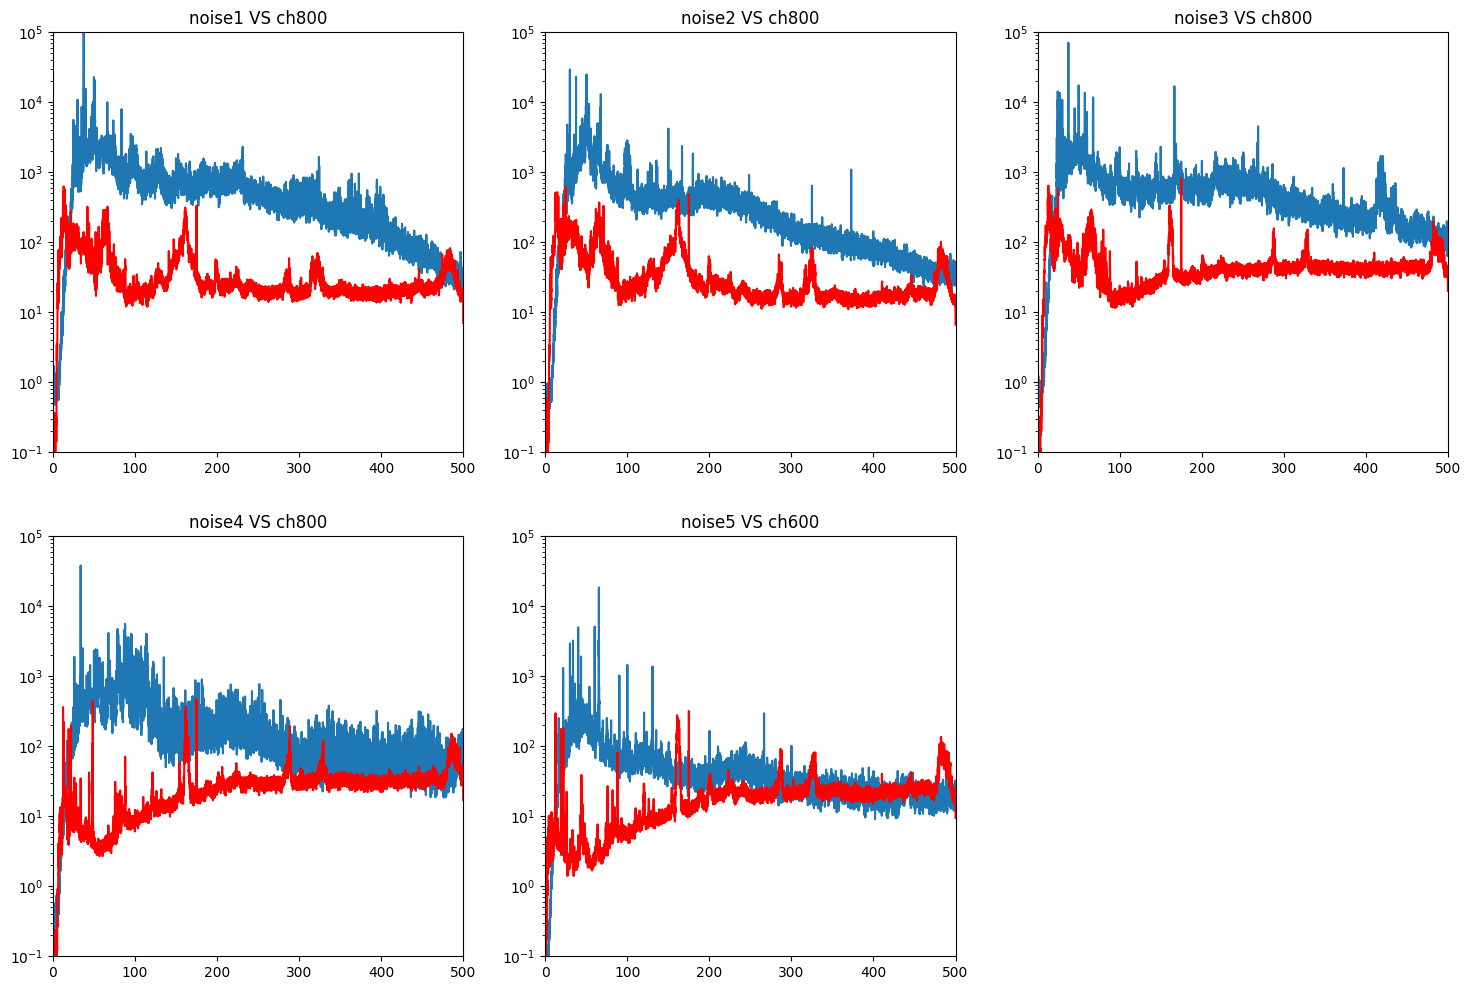

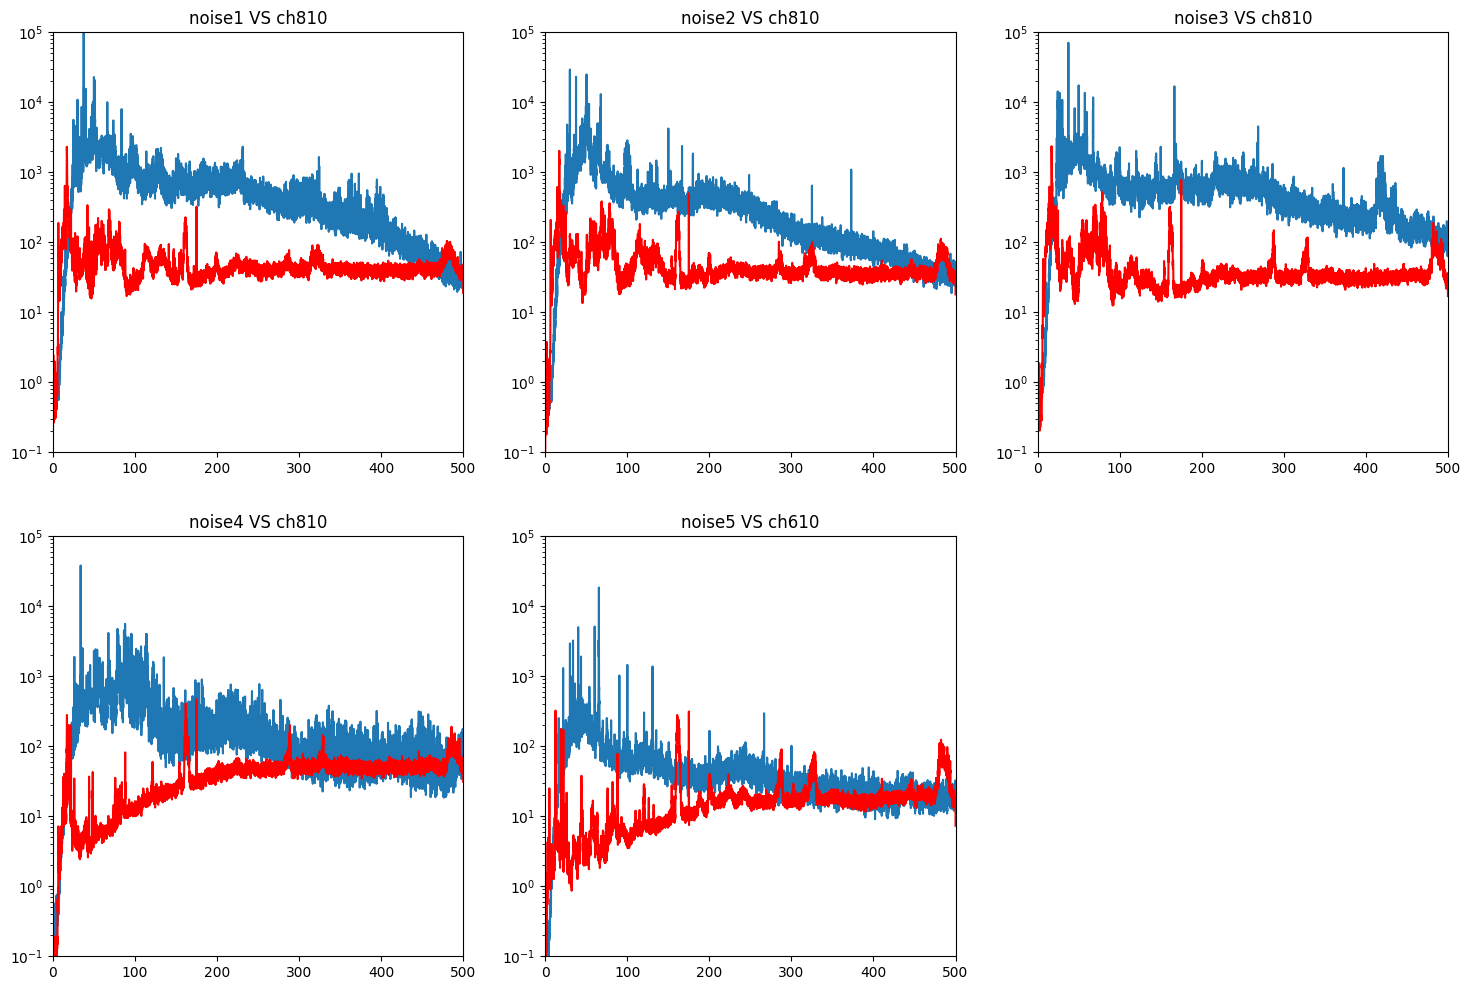

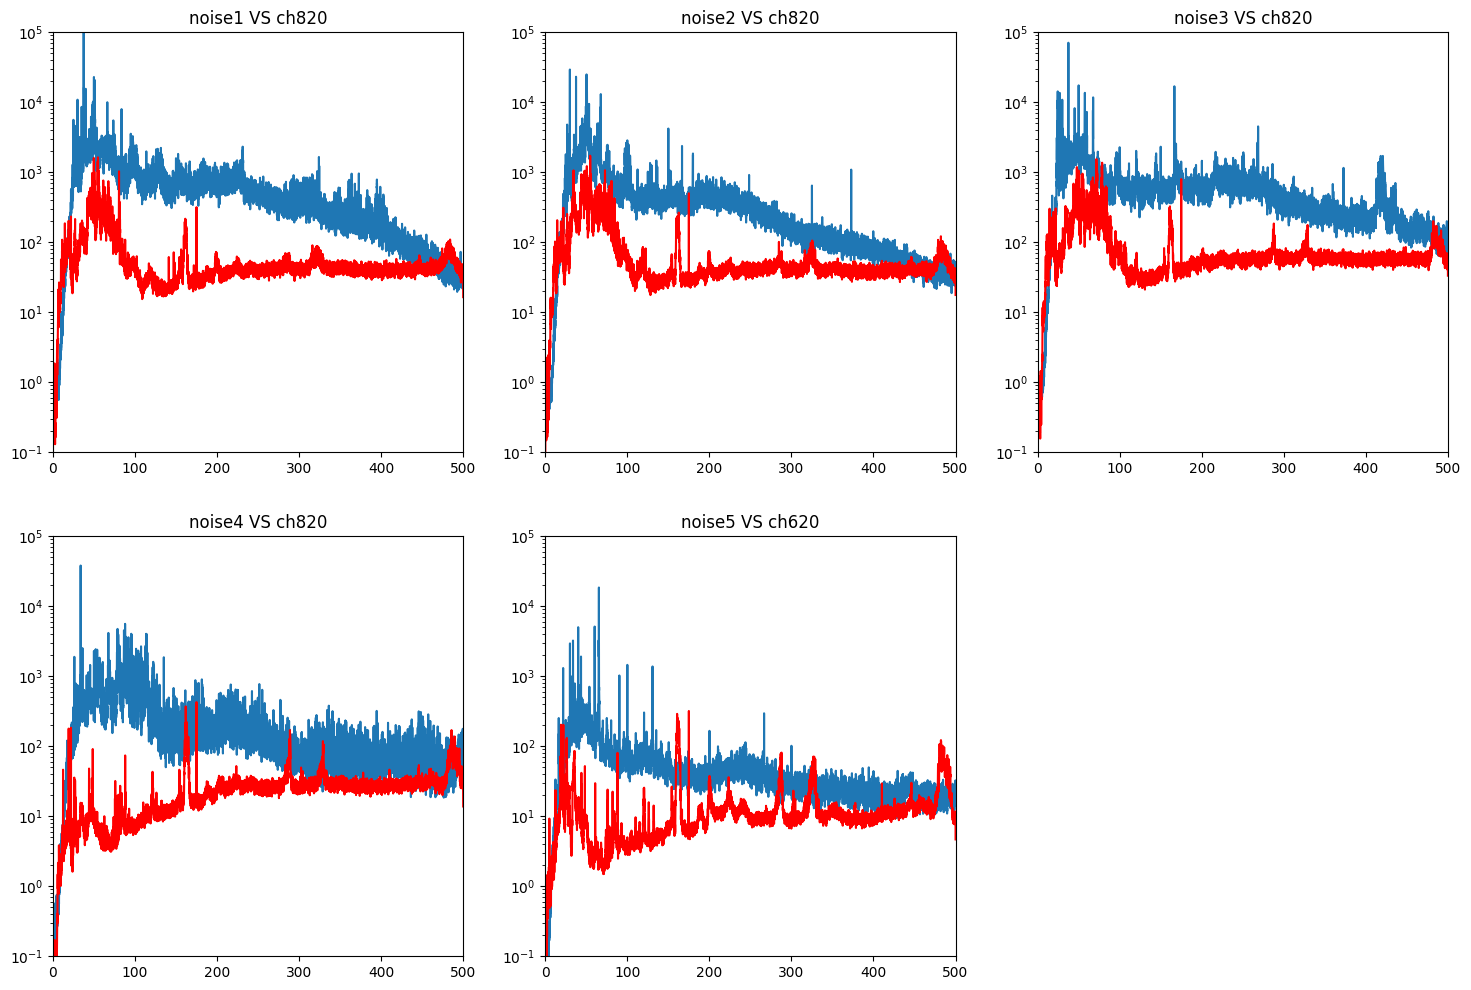

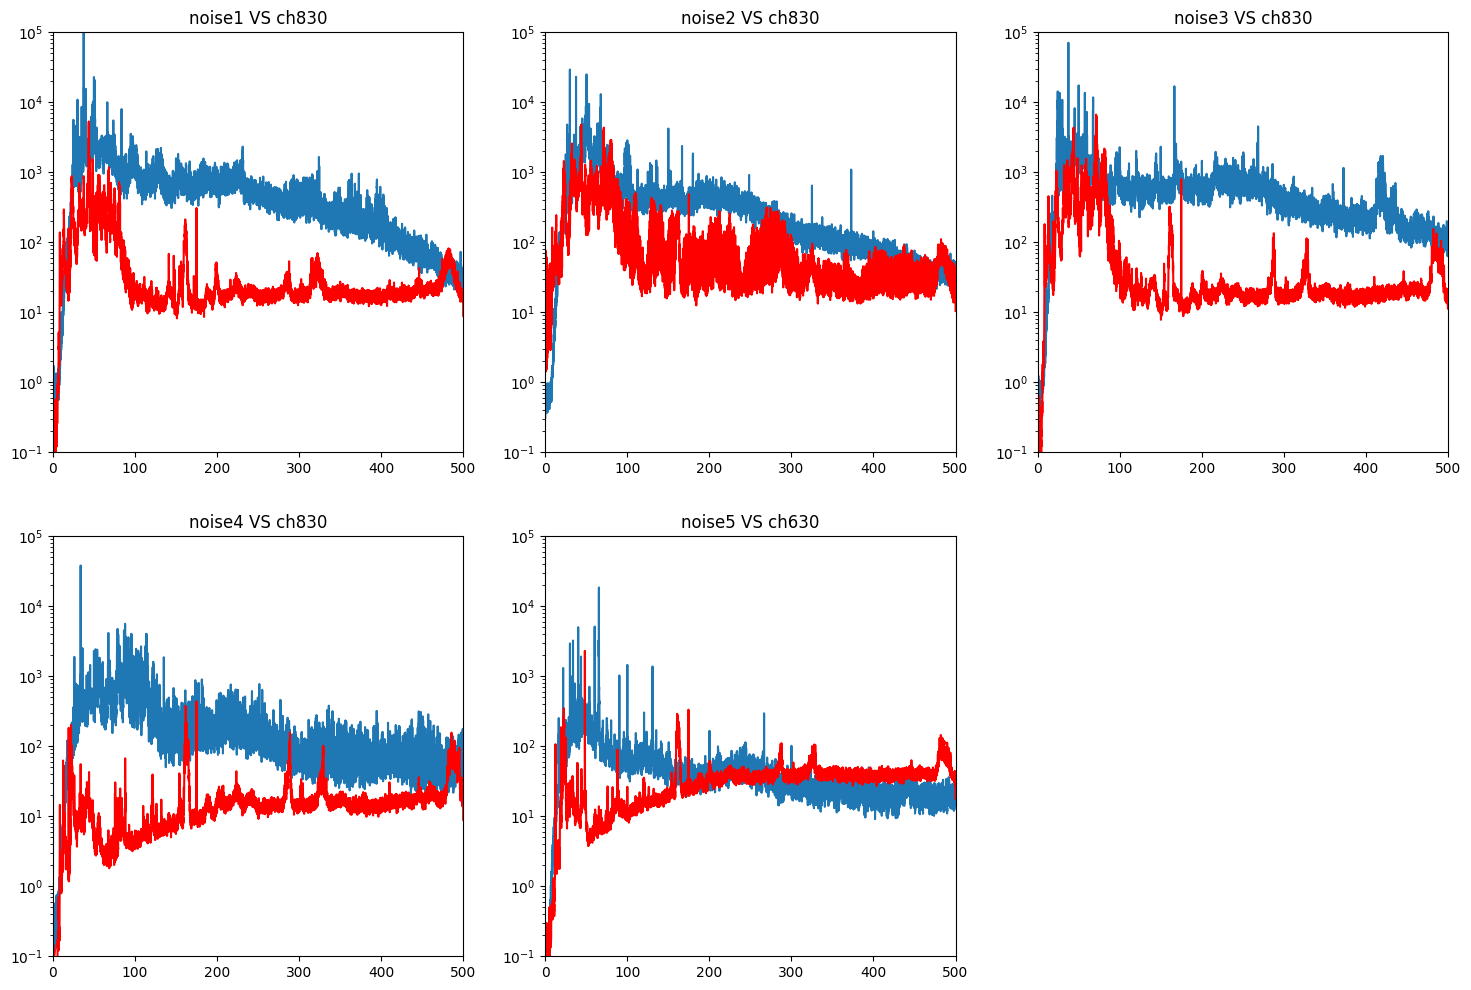

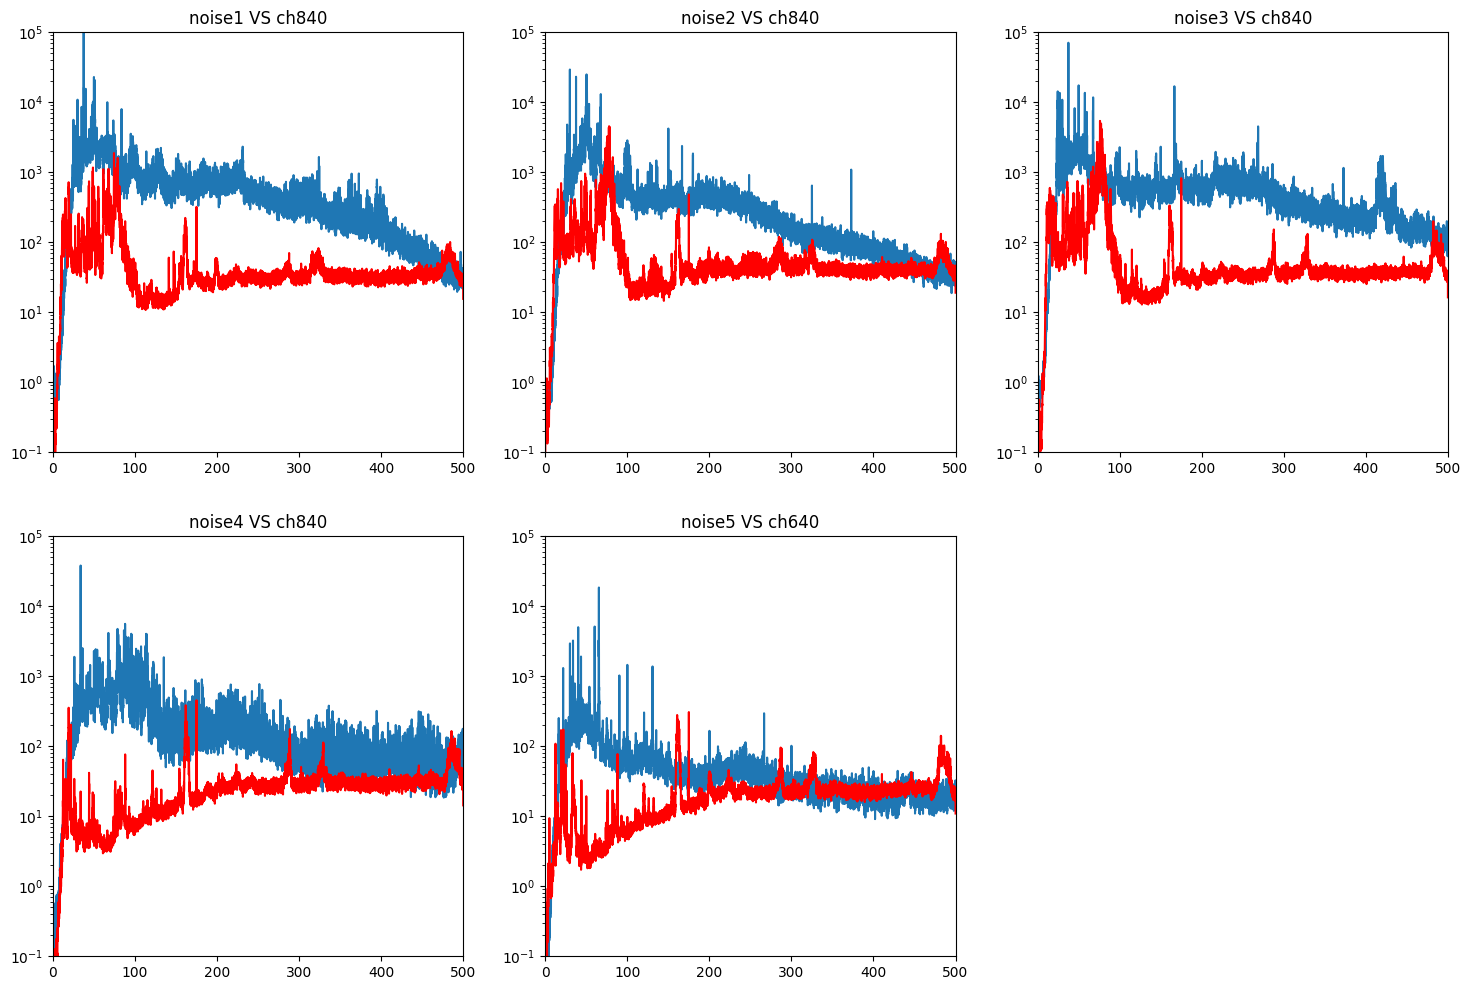

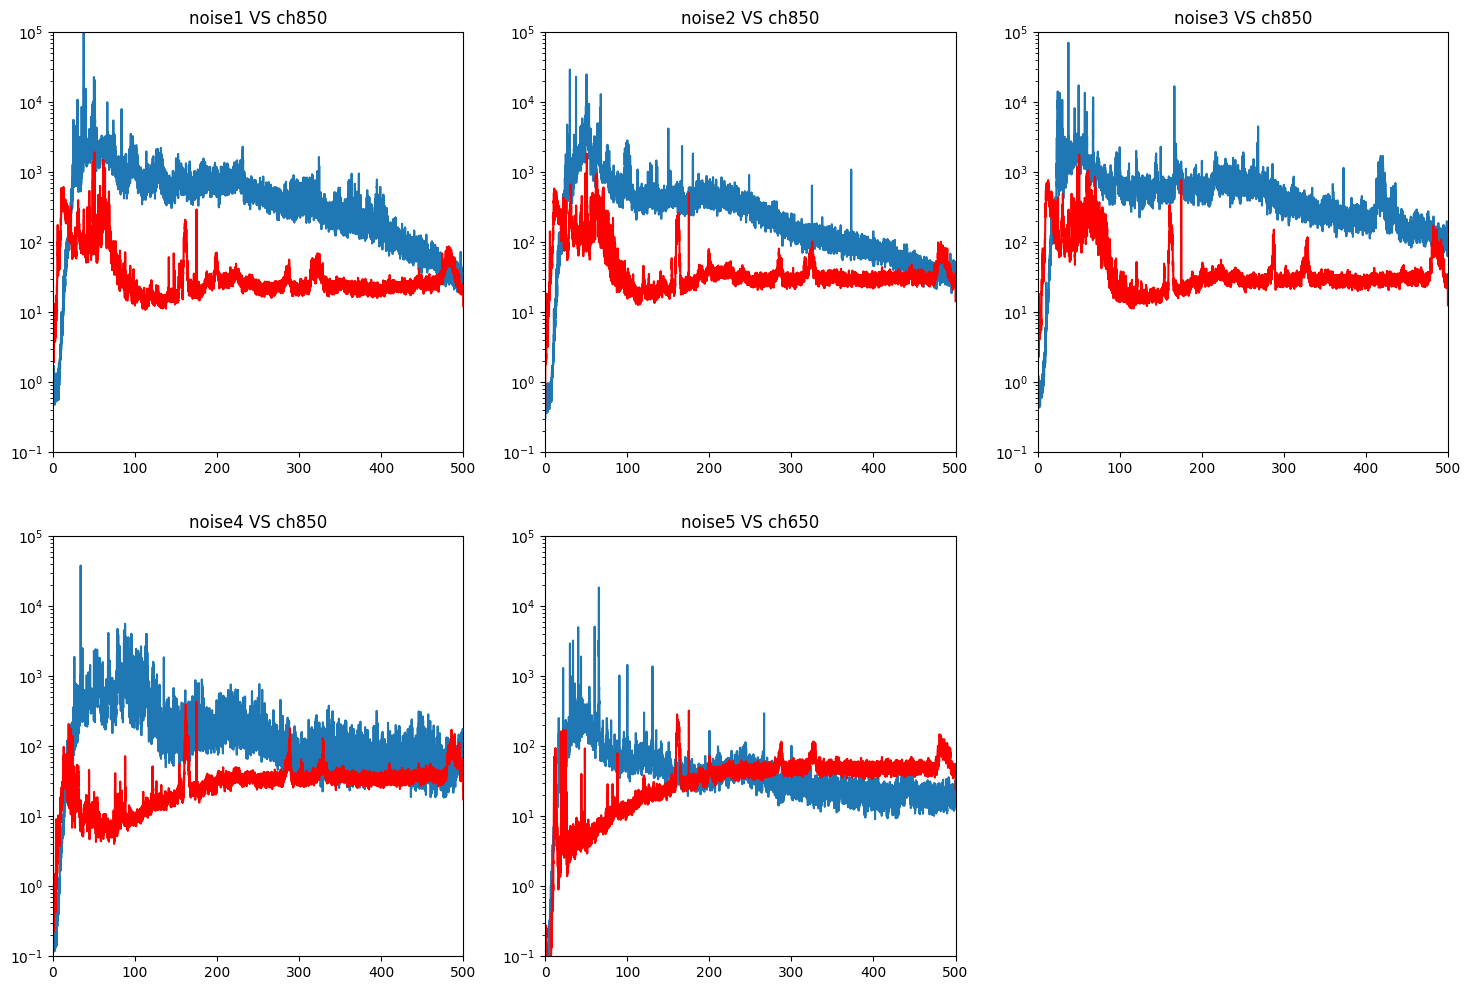

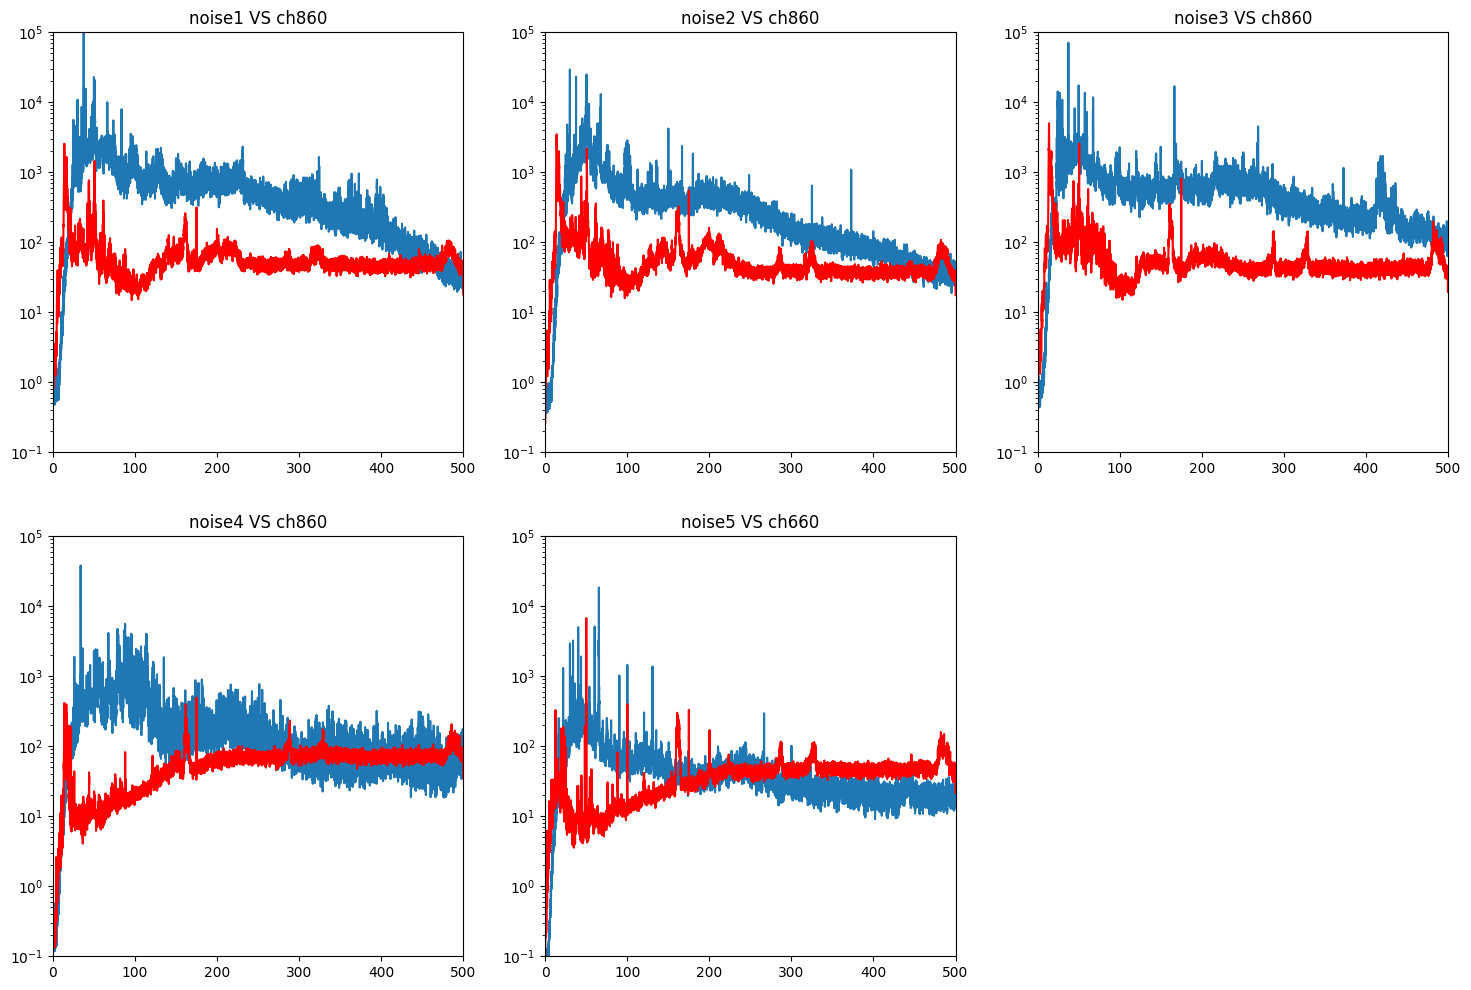

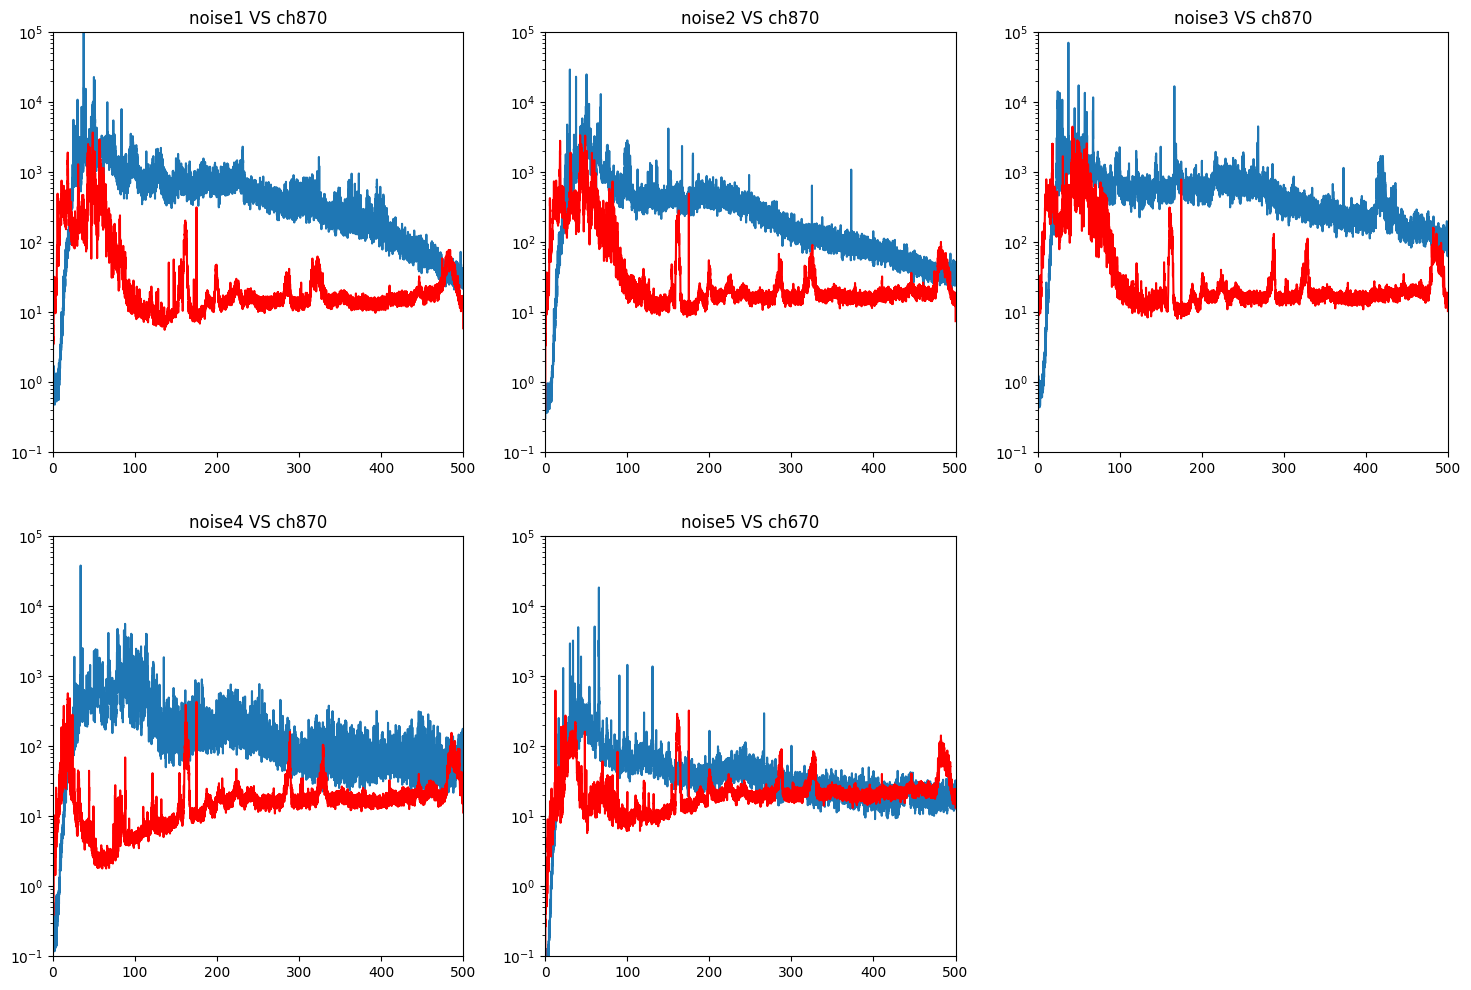

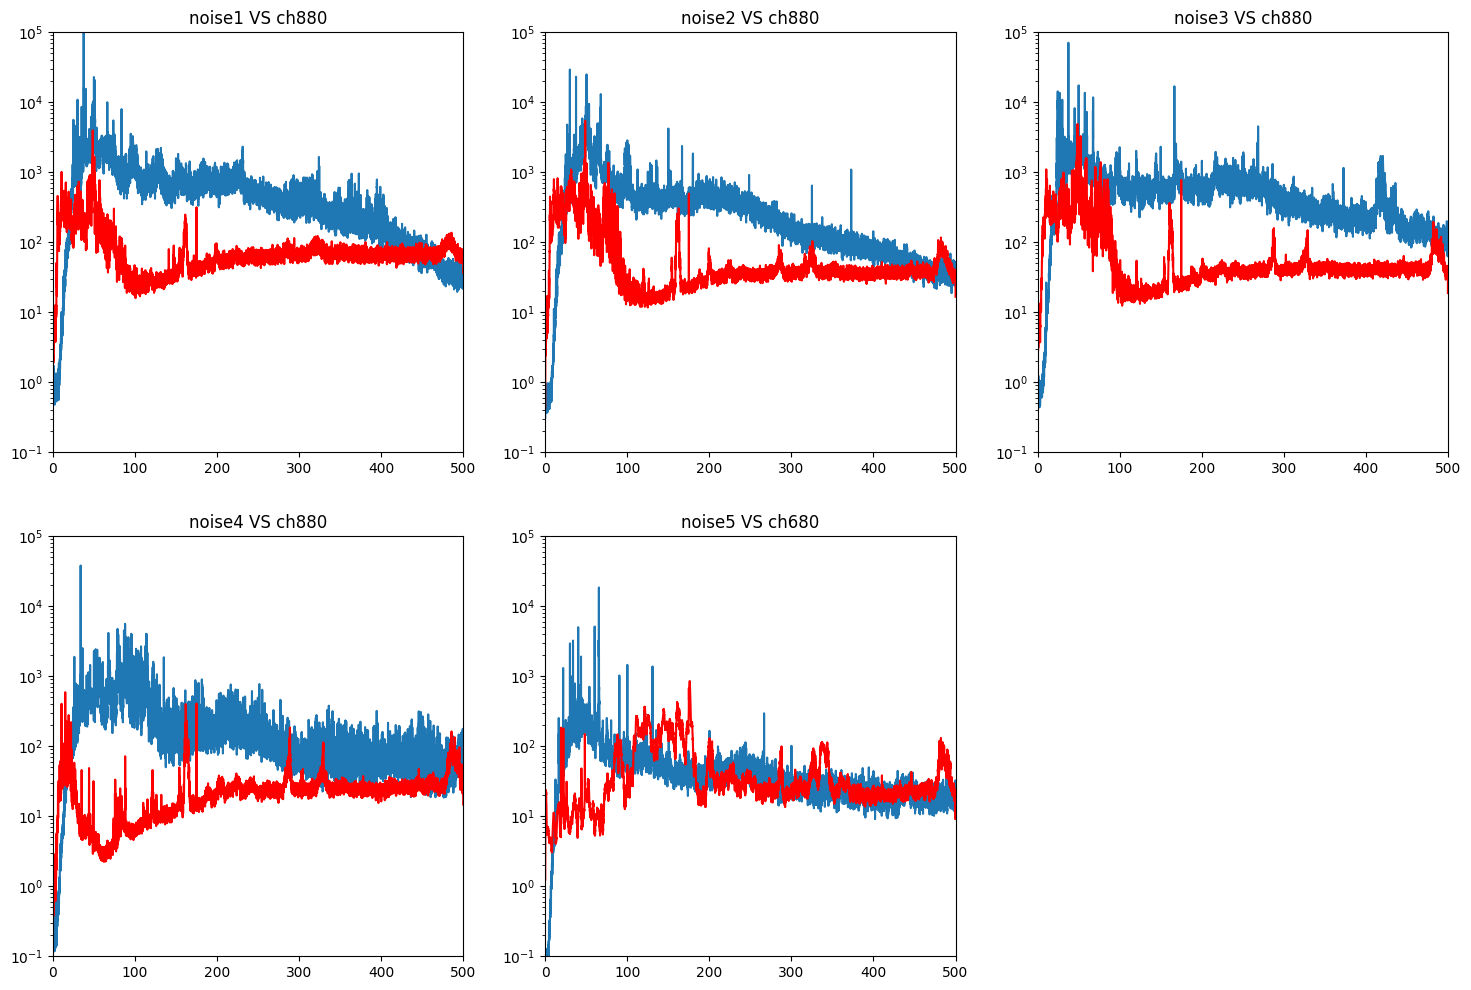

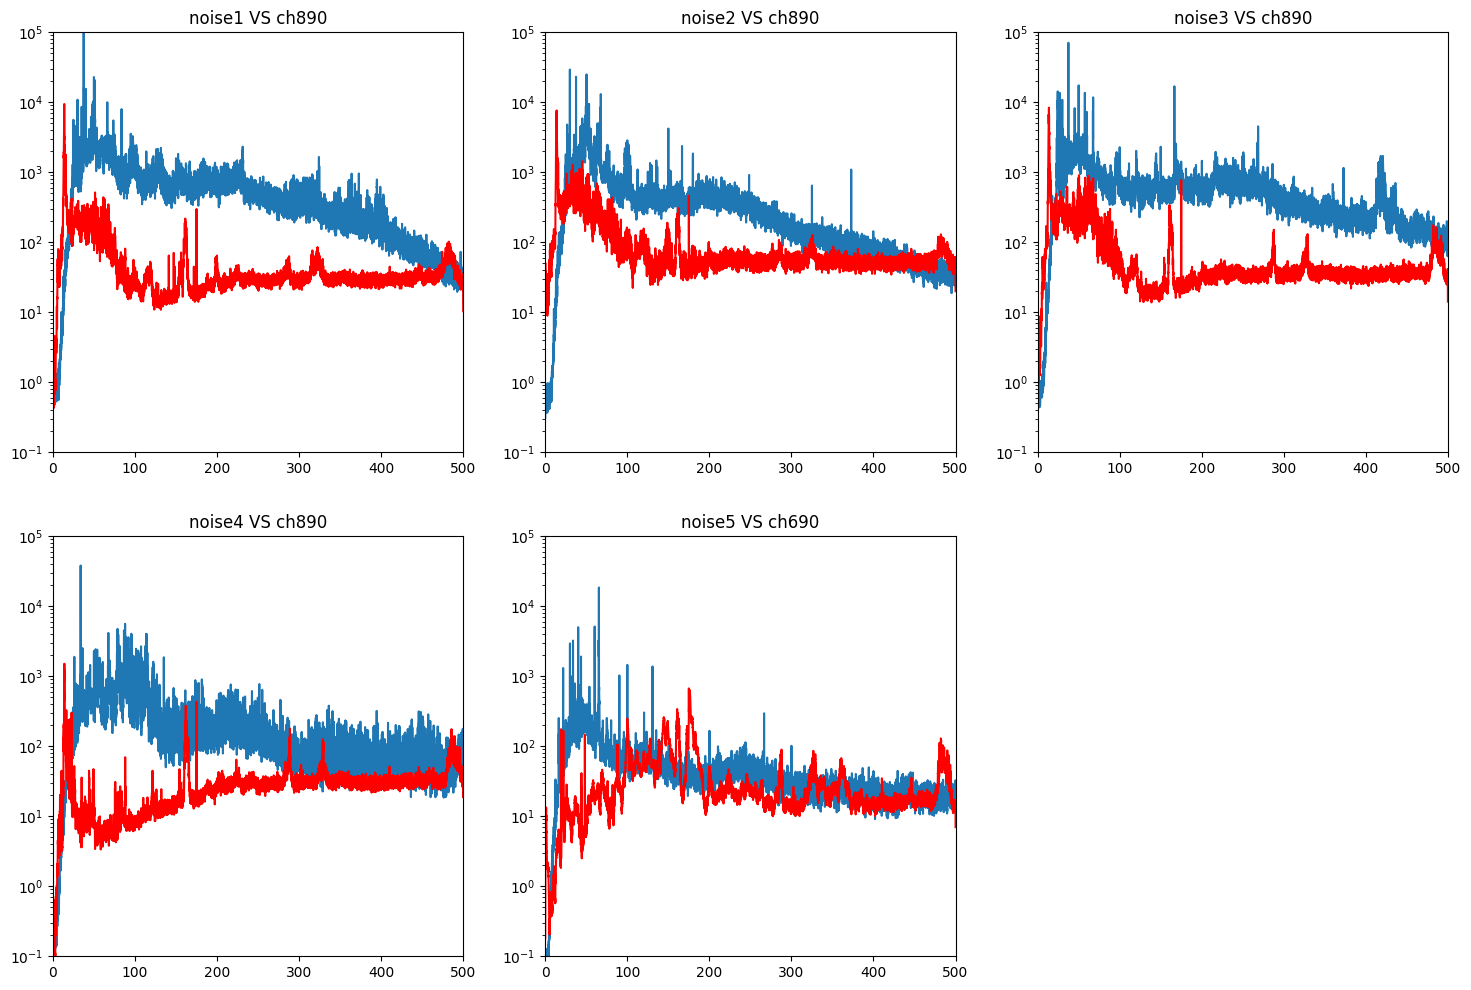

In [2]:
for i in range(0,10):
    path = '../output/c_noise_vs_das_psd'+str(i)+'.png'
    axis  = [0,500,0.1,100000]
    ch_list = [800+10*i , 800+10*i , 800+10*i , 800+10*i , 600+10*i]
    noiseVSdas(ch_list,axis,path)